## City Similarity

### Business Problem
Company XYZ is an Online Travel Agent, such as Expedia, Booking.com, etc.

They store their data in JSON ﬁles. Each row in the json shows all diﬀerent cities which have been searched for by a user within the same session (as well as some other info about the user). That is, if I go to company XYZ site and look for hotels in NY and SF within the same session, the corresponding JSON row will show my user id, some basic info about me and the two cities.<br>
Travel sites are browsed by two kinds of users. Users who are actually planning a trip and users who just dream about a vacation. The ﬁrst ones have obviously a much higher purchasing intent. Users planning a trip often search for cities close to each other, while users who search for cities far away from each other are often just dreaming about a vacation. That is, a user searching for LA, SF and Las Vegas in the same session is much more likely to book a hotel than a user searching for NY, Paris, Kuala Lumpur (makes sense, right?). Based on this idea, come up with an algorithm that clusters sessions into two groups: high intent and low intent. Explain all assumptions you make along the way.

In [1]:
import warnings
warnings.simplefilter('ignore')

import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### Parse JSON File

In [2]:
with open("city_search.json",'rt') as inf:
    sessions = json.load(inf)

In [3]:
def parse_json(sessions):
    session_id = []
    unix_timestamp = []
    cities = []
    user_id = []
    joining_date = []
    country = []

    for i in sessions:
        session_id.append(i['session_id'][0])
        unix_timestamp.append(i['unix_timestamp'][0])
        cities.append(i['cities'][0])
        user_id.append(i['user'][0][0]['user_id'])
        joining_date.append(i['user'][0][0]['joining_date'])
        country.append(i['user'][0][0]['country'])
    
    cols = ['session_id','unix_timestamp','cities','user_id','joining_date','country']
    final = pd.DataFrame({'session_id':session_id,'unix_timestamp':unix_timestamp,'cities':
              cities,'user_id':user_id,'joining_date':joining_date,'country':country},columns = cols)
    return(final)

In [4]:
data = parse_json(sessions)
data['joining_date'] = pd.to_datetime(data['joining_date'])
data.head()

session_id  unix_timestamp  \
0  X061RFWB06K9V      1442503708   
1  5AZ2X2A9BHH5U      1441353991   
2  SHTB4IYAX4PX6      1440843490   
3  JBRB8MZGTX3M4      1427268063   
4  YJCMPURC2FL9C      1430559067   

                                         cities  user_id joining_date country  
0                        New York NY, Newark NJ     2024   2015-03-22      UK  
1  New York NY, Jersey City NJ, Philadelphia PA     2853   2015-03-28      DE  
2                                San Antonio TX    10958   2015-03-06      UK  
3                                   Edmonton AB     7693   2015-03-12      IT  
4                        Phoenix AZ, Houston TX     7506   2015-02-28      UK

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   session_id      20022 non-null  object        
 1   unix_timestamp  20022 non-null  int64         
 2   cities          20022 non-null  object        
 3   user_id         20022 non-null  int64         
 4   joining_date    20022 non-null  datetime64[ns]
 5   country         20022 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 938.7+ KB


In [6]:
data.describe()

unix_timestamp       user_id
count    2.002200e+04  20022.000000
mean     1.435049e+09   5517.930626
std      5.000951e+06   3204.762591
min      1.425095e+09      4.000000
25%      1.430775e+09   2716.000000
50%      1.434986e+09   5504.000000
75%      1.439373e+09   8329.250000
max      1.443747e+09  11000.000000

In [7]:
data.isnull().sum()

session_id        0
unix_timestamp    0
cities            0
user_id           0
joining_date      0
country           0
dtype: int64

In [8]:
len(data['session_id'].unique())

20022

In [9]:
len(data['user_id'].unique())

5777

There are 20,000 sessions created by 5777 unique users.

# Question 1
There was a bug in the code and one country didn't get logged. It just shows up as an empty field (""). Can you guess which country was that? How?

Filter to the country that has empty string

In [10]:
data[data['country']== ""]

session_id  unix_timestamp                                cities  \
6      YOVUIM79SGS5Y      1443171887               Montreal QC, Chicago IL   
7      SHXEY67QWKP9K      1431766104               Calgary AB, New York NY   
9      UY49RTVRX3GL7      1439104667                           New York NY   
19     YQAEPPG214CNU      1439713760               Toronto ON, New York NY   
37     51H4C2DEYXG5D      1436444694                           New York NY   
...              ...             ...                                   ...   
19996  0TXH0SHVBIUZ6      1441074323                        Los Angeles CA   
19998  KRQCDHK5X2F34      1436939475                 Toronto ON, Oshawa ON   
20009  1Y6XYIDGRIJMD      1430647138  Chicago IL, Milwaukee WI, Madison WI   
20014  DT060KZFN83KM      1428811550                        Los Angeles CA   
20017  17WJGZOEFEI4W      1430545204               Chicago IL, Montreal QC   

       user_id joining_date country  
6         8831   2015-03-02          
7          587   2015-03-16          
9         5995   2015-03-21          
19         957   2015-03-30          
37        5433   2015-03-05          
...        ...          ...     ...  
19996     2550   2015-03-21          
19998    10468   2015-03-14          
20009     5116   2015-03-22          
20014     5726   2015-03-31          
20017     4360   2015-03-21          

[2820 rows x 6 columns]

In [11]:
data['country'].value_counts()

US    3876
DE    3638
UK    3555
      2820
FR    2298
ES    1953
IT    1882
Name: country, dtype: int64

Given the current dataset, since there are little information about the dataset, one information that could be used to guess the country is the search time. Since people in different countries will search in similar local time, we can use this information to guess the country.

In [12]:
data['time'] = pd.to_datetime(data['unix_timestamp'], unit='s')
data['hour'] = data['time'].dt.hour
data.head()

session_id  unix_timestamp  \
0  X061RFWB06K9V      1442503708   
1  5AZ2X2A9BHH5U      1441353991   
2  SHTB4IYAX4PX6      1440843490   
3  JBRB8MZGTX3M4      1427268063   
4  YJCMPURC2FL9C      1430559067   

                                         cities  user_id joining_date country  \
0                        New York NY, Newark NJ     2024   2015-03-22      UK   
1  New York NY, Jersey City NJ, Philadelphia PA     2853   2015-03-28      DE   
2                                San Antonio TX    10958   2015-03-06      UK   
3                                   Edmonton AB     7693   2015-03-12      IT   
4                        Phoenix AZ, Houston TX     7506   2015-02-28      UK   

                 time  hour  
0 2015-09-17 15:28:28    15  
1 2015-09-04 08:06:31     8  
2 2015-08-29 10:18:10    10  
3 2015-03-25 07:21:03     7  
4 2015-05-02 09:31:07     9

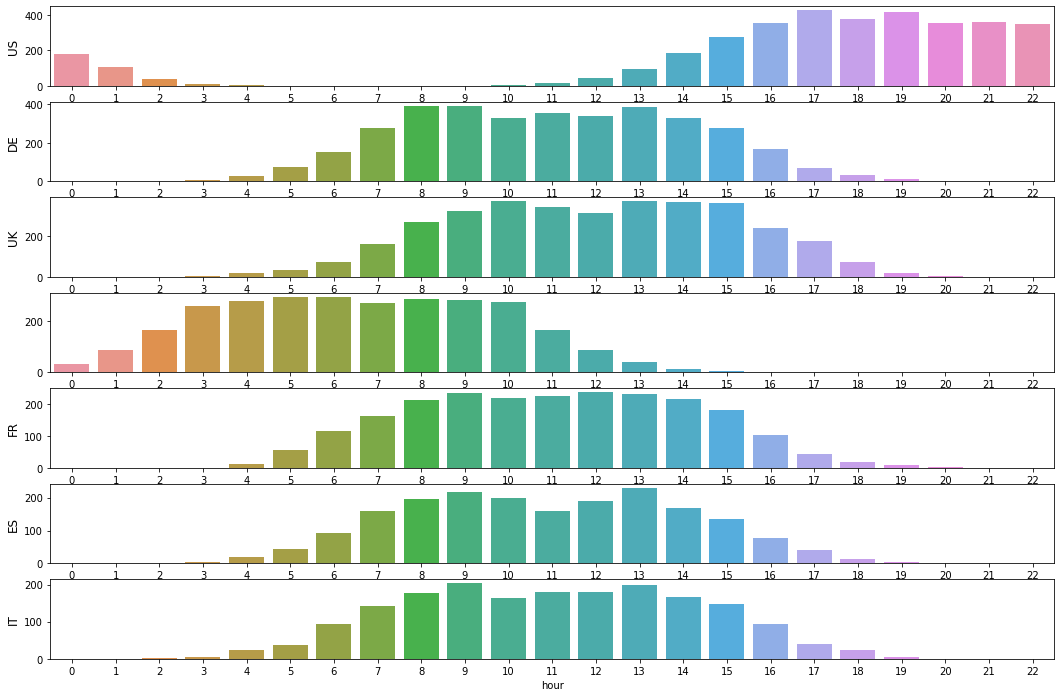

In [13]:
country_list = ['US','DE','UK','','FR','ES','IT']
order = list(range(0,23))
fig,ax = plt.subplots(nrows=7, ncols=1, figsize=(18, 12))
for i in range(len(country_list)):
    sns.countplot(x='hour', data = data[data['country'] == country_list[i]], ax = ax[i], order = order)
    ax[i].set_ylabel(country_list[i],fontsize = 12)
    
plt.show()



Based on above figure, we can see that, for the unknown country, their peak search time has around 12 hours difference with United States, and around 5 hours difference with Europe. Based on the geographic locations of each country, it seems that this missing country is in Asia. Possible countries include China and Japan.

# Question 2
For each city, find the most likely city to be also searched for within the same session. Cluster similar cities together.

In [14]:
city_pair = data['cities'].apply(lambda x: x.strip().split(','))
city_pair

0                               [New York NY,  Newark NJ]
1        [New York NY,  Jersey City NJ,  Philadelphia PA]
2                                        [San Antonio TX]
3                                           [Edmonton AB]
4                               [Phoenix AZ,  Houston TX]
                               ...                       
20017                          [Chicago IL,  Montreal QC]
20018                                        [Chicago IL]
20019                                        [Chicago IL]
20020                          [Calgary AB,  New York NY]
20021                                       [San Jose CA]
Name: cities, Length: 20022, dtype: object

maps: dictionary containing the count of cities<br>
city_list: list of unique cities  

In [15]:
maps = {}
city_list = []
index = 0
for item in city_pair:
    for i in item:
        x = i.strip()
        if x not in maps:
            maps[x] = index
            index+=1
            city_list.append(x)

            


In [16]:
len(city_list)

89

#### Constructing a similarity Matrix

In [18]:
# calculate matrix similarity
pair_matrix = np.zeros((89, 89))

for item in city_pair:
    if len(item) == 1:
        continue
    for i in range(len(item)-1):
        x = item[i].strip()
        index1 = maps[x]
        
    for j in range(i+1,len(item)):
        y = item[j].strip()
        index2 = maps[y]
        
        pair_matrix[index1,index2]+= 1
        pair_matrix[index2,index1]+= 1
        


In [19]:
# create dataframe
df_similarity = pd.DataFrame(pair_matrix, index=city_list, columns=city_list)
df_similarity.head(10)

New York NY  Newark NJ  Jersey City NJ  Philadelphia PA  \
New York NY              0.0      137.0           238.0            175.0   
Newark NJ              137.0        0.0           170.0            116.0   
Jersey City NJ         238.0      170.0             0.0             75.0   
Philadelphia PA        175.0      116.0            75.0              0.0   
San Antonio TX          49.0        0.0             0.0              0.0   
Edmonton AB             36.0        0.0             0.0              0.0   
Phoenix AZ              53.0        0.0             0.0              0.0   
Houston TX             171.0        0.0             0.0              9.0   
San Diego CA            52.0        0.0             0.0              0.0   
Montreal QC            255.0        0.0             0.0             20.0   

                 San Antonio TX  Edmonton AB  Phoenix AZ  Houston TX  \
New York NY                49.0         36.0        53.0       171.0   
Newark NJ                   0.0          0.0         0.0         0.0   
Jersey City NJ              0.0          0.0         0.0         0.0   
Philadelphia PA             0.0          0.0         0.0         9.0   
San Antonio TX              0.0          0.0         0.0        37.0   
Edmonton AB                 0.0          0.0         0.0        10.0   
Phoenix AZ                  0.0          0.0         0.0        15.0   
Houston TX                 37.0         10.0        15.0         0.0   
San Diego CA                0.0          0.0         0.0        10.0   
Montreal QC                19.0         10.0        25.0        57.0   

                 San Diego CA  Montreal QC  ...  Birmingham AL  Nashville TN  \
New York NY              52.0        255.0  ...            0.0           0.0   
Newark NJ                 0.0          0.0  ...            0.0           0.0   
Jersey City NJ            0.0          0.0  ...            0.0           0.0   
Philadelphia PA           0.0         20.0  ...            0.0           0.0   
San Antonio TX            0.0         19.0  ...            0.0           0.0   
Edmonton AB               0.0         10.0  ...            0.0           0.0   
Phoenix AZ                0.0         25.0  ...            0.0           0.0   
Houston TX               10.0         57.0  ...            0.0           0.0   
San Diego CA              0.0         12.0  ...            0.0           0.0   
Montreal QC              12.0          0.0  ...            0.0           0.0   

                 Omaha NE  Kansas City MO  Raleigh NC  Greensboro NC  \
New York NY           0.0             0.0         0.0            0.0   
Newark NJ             0.0             0.0         0.0            0.0   
Jersey City NJ        0.0             0.0         0.0            0.0   
Philadelphia PA       0.0             0.0         0.0            0.0   
San Antonio TX        0.0             0.0         0.0            0.0   
Edmonton AB           0.0             0.0         0.0            0.0   
Phoenix AZ            0.0             0.0         0.0            0.0   
Houston TX            0.0             0.0         0.0            0.0   
San Diego CA          0.0             0.0         0.0            0.0   
Montreal QC           0.0             0.0         0.0            0.0   

                 New Orleans LA  Charlotte NC  Lincoln NE  Memphis TN  
New York NY                 0.0           0.0         0.0         0.0  
Newark NJ                   0.0           0.0         0.0         0.0  
Jersey City NJ              0.0           0.0         0.0         0.0  
Philadelphia PA             0.0           0.0         0.0         0.0  
San Antonio TX              0.0           0.0         0.0         0.0  
Edmonton AB                 0.0           0.0         0.0         0.0  
Phoenix AZ                  0.0           0.0         0.0         0.0  
Houston TX                  0.0           0.0         0.0         0.0  
San Diego CA                0.0           0.0         0.0        

In [21]:
from sklearn.preprocessing import normalize
df_similarity_normed = normalize(df_similarity,axis=1)

#### Computing Cosine Similarity between cities

In [22]:
#Taking dot product of normalized values is cosine similarity
city_similarity = df_similarity_normed.dot(df_similarity_normed.T)
city_similarity = pd.DataFrame(city_similarity,
                               index = df_similarity.index,
                               columns = df_similarity.index)
city_similarity.head()

New York NY  Newark NJ  Jersey City NJ  Philadelphia PA  \
New York NY         1.000000   0.343893        0.173783         0.411095   
Newark NJ           0.343893   1.000000        0.554247         0.653015   
Jersey City NJ      0.173783   0.554247        1.000000         0.873250   
Philadelphia PA     0.411095   0.653015        0.873250         1.000000   
San Antonio TX      0.367779   0.225811        0.321562         0.399078   

                 San Antonio TX  Edmonton AB  Phoenix AZ  Houston TX  \
New York NY            0.367779     0.371376    0.445226    0.537958   
Newark NJ              0.225811     0.212087    0.325565    0.398674   
Jersey City NJ         0.321562     0.302019    0.463615    0.552518   
Philadelphia PA        0.399078     0.369641    0.558397    0.651879   
San Antonio TX         1.000000     0.325744    0.469517    0.752463   

                 San Diego CA  Montreal QC  ...  Birmingham AL  Nashville TN  \
New York NY          0.388684     0.544022  ...            0.0           0.0   
Newark NJ            0.321230     0.369678  ...            0.0           0.0   
Jersey City NJ       0.457442     0.511402  ...            0.0           0.0   
Philadelphia PA      0.537270     0.599564  ...            0.0           0.0   
San Antonio TX       0.427479     0.486393  ...            0.0           0.0   

                 Omaha NE  Kansas City MO  Raleigh NC  Greensboro NC  \
New York NY           0.0             0.0         0.0            0.0   
Newark NJ             0.0             0.0         0.0            0.0   
Jersey City NJ        0.0             0.0         0.0            0.0   
Philadelphia PA       0.0             0.0         0.0            0.0   
San Antonio TX        0.0             0.0         0.0            0.0   

                 New Orleans LA  Charlotte NC  Lincoln NE  Memphis TN  
New York NY                 0.0           0.0         0.0         0.0  
Newark NJ                   0.0           0.0         0.0         0.0  
Jersey City NJ              0.0           0.0         0.0         0.0  
Philadelphia PA             0.0           0.0         0.0         0.0  
San Antonio TX              0.0           0.0         0.0         0.0  

[5 rows x 89 columns]

#### Find Similar cities based on cosine similarity

In [27]:
### find top K most similar of each city
def most_similar(s,topk):
    # [0] must be itself
    similar_ones = s.sort_values(ascending=False)[1:topk+1].index.values
    return pd.Series(similar_ones,index = ["similar#{}".format(i) for i in range(1,topk+1)])

most_similar_cities = city_similarity.apply(most_similar,topk=2,axis=1)

In [28]:
most_similar_cities

similar#1      similar#2
New York NY          San Jose CA   Vancouver BC
Newark NJ           Baltimore MD      Boston MA
Jersey City NJ   Philadelphia PA   Baltimore MD
Philadelphia PA   Jersey City NJ   Baltimore MD
San Antonio TX        Houston TX      Dallas TX
...                          ...            ...
Greensboro NC       Charlotte NC     Raleigh NC
New Orleans LA        Memphis TN     Atlanta GA
Charlotte NC       Greensboro NC     Raleigh NC
Lincoln NE        Kansas City MO       Omaha NE
Memphis TN        New Orleans LA  Birmingham AL

[89 rows x 2 columns]

Based on the cities searched by the users in a single session, Newark is most similar to Baltimore and Jersey City is similar to Philadelphia.

In [29]:
#Another way to get top similar city

sim = pd.DataFrame(city_similarity.apply(lambda x: x.nlargest(2).idxmin(),axis=1)).reset_index()
sim = sim.rename(columns = {'index':'city',0:'similar'})
sim

city          similar
0       New York NY      San Jose CA
1         Newark NJ     Baltimore MD
2    Jersey City NJ  Philadelphia PA
3   Philadelphia PA   Jersey City NJ
4    San Antonio TX       Houston TX
..              ...              ...
84    Greensboro NC     Charlotte NC
85   New Orleans LA       Memphis TN
86     Charlotte NC    Greensboro NC
87       Lincoln NE   Kansas City MO
88       Memphis TN   New Orleans LA

[89 rows x 2 columns]

### Answer question 3
Come up with an algorithm that clusters sessions into two groups: high intent and low intent. Explain all assumptions you make along the way.

To start with, we will count the number of cities searched in one session.

In [31]:
data_cp = data
data_cp['city'] = data_cp['cities'].apply(lambda x:x.split(','))

In [32]:
#data_cp.city is a series that's why we use map.
data_cp['num_searched'] = data_cp.city.map(len)

In [33]:
data_cp.head()

session_id  unix_timestamp  \
0  X061RFWB06K9V      1442503708   
1  5AZ2X2A9BHH5U      1441353991   
2  SHTB4IYAX4PX6      1440843490   
3  JBRB8MZGTX3M4      1427268063   
4  YJCMPURC2FL9C      1430559067   

                                         cities  user_id joining_date country  \
0                        New York NY, Newark NJ     2024   2015-03-22      UK   
1  New York NY, Jersey City NJ, Philadelphia PA     2853   2015-03-28      DE   
2                                San Antonio TX    10958   2015-03-06      UK   
3                                   Edmonton AB     7693   2015-03-12      IT   
4                        Phoenix AZ, Houston TX     7506   2015-02-28      UK   

                 time  hour                                              city  \
0 2015-09-17 15:28:28    15                         [New York NY,  Newark NJ]   
1 2015-09-04 08:06:31     8  [New York NY,  Jersey City NJ,  Philadelphia PA]   
2 2015-08-29 10:18:10    10                                  [San Antonio TX]   
3 2015-03-25 07:21:03     7                                     [Edmonton AB]   
4 2015-05-02 09:31:07     9                         [Phoenix AZ,  Houston TX]   

   num_searched  
0             2  
1             3  
2             1  
3             1  
4             2

Defintion of high intent users: Users who search for cities that are close to each other <br>
Definition of low intent users: Users who search for cities that are far from each other e.g New York, London, Houston etc.

We will write a function to calculate euclidean distance between 2 cosine similarity points. 

In [44]:
def search_distance(city):
    """
    input: 
        city: a list of cities included in the search
        similar2dist: a function which maps similarity to distance
    return: 
        distance: distance among cities in the search
    """
    sumdist = 0
    total = len(city)
    if len(city) == 1:
        return 0 
    
    for index1 in range(total-1):
        x1 = city[index1].strip()
        for index2 in range(index1+1,total):
            x2 = city[index2].strip()
            sim = city_similarity.loc[x1,x2]
            #dist = np.sqrt(sim*(1-sim))
            dist = distance.euclidean(sim,1-sim)
            sumdist += dist
    return(sumdist/total)
           

In [45]:
from scipy.spatial import distance
distances = data_cp['city'].map(lambda x:search_distance(x))


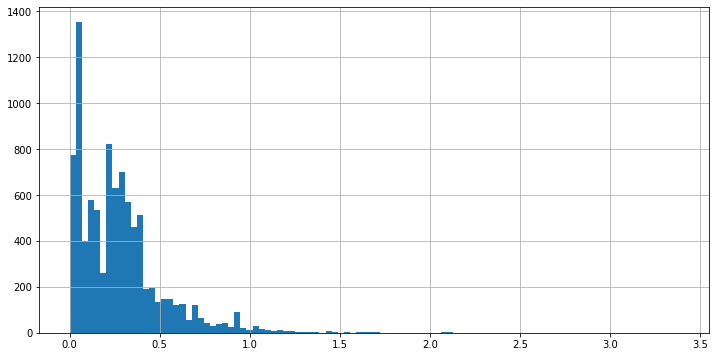

In [46]:
distances[distances>0].hist(bins=100,figsize=(12,6))

In [50]:
high_intent = pd.DataFrame(data_cp.loc[(distances <= 0.7),['user_id','num_searched','city']])
high_intent

user_id  num_searched  \
0         2024             2   
1         2853             3   
2        10958             1   
3         7693             1   
4         7506             2   
5         3743             1   
6         8831             2   
7          587             2   
8          365             2   
9         5995             1   
10        7034             1   
11        5723             1   
12        8531             1   
13        5634             2   
14         259             2   
15        3607             1   
16        8618             2   
17       10128             1   
18         297             3   
19         957             2   
20        3073             3   
21         152             1   
22        4265             1   
23         892             1   
24        7688             1   
25        9825             4   
26        1631             2   
27        6616             1   
28        1478             4   
29        5928             2   
30       10795             1   
31        7387             1   
32        6133             2   
33        4592             2   
34       10144             1   
35        2179             1   
36        2540             2   
37        5433             1   
38        3427             3   
39        7206             3   
40        4643             2   
41        1949             1   
42        1874             1   
43        9353             1   
44       10918             1   
45        1203             2   
46        5385             2   
47        9157             1   
48        9122             1   
49        6236             1   
50        2504             1   
51       10175             2   
52         297             1   
53        9121             2   
54         164             1   
55        8390             1   
56        4553             2   
57        2501             1   
58        4359             2   
59        1673             2   
60        8009             1   
61         766             1   
62        8294             1   
63        7018             2   
64        8617             1   
65        8279             2   
66        1616             1   
67        8283             1   
68       10940             2   
69        1752             2   
70        7759             1   
71        2340             1   
72        2956             2   
73        5238             1   
74        4662             3   
75        5706             3   
76        7477             2   
77        6976             2   
78       10210             2   
79        4586             1   
80        9002             2   
81         782             1   
82        8643             1   
83        2069             1   
84        8513             2   
85        3718             1   
86        8691             1   
87        5419             1   
88       10221             3   
89         712             2   
90        9013             2   
91        6429             1   
92        9598             2   
93        9948             3   
94        4590             1   
95        1103             1   
96       10145             1   
97        5725             2   
98         666             1   
99       10297             2   
100       4289             1   
101        599             2   
102       3768             1   
103       6200             2   
104       5865             3   
105       9516             1   
106       9385             2   
107       1891             1   
108       2143             1   
109       6951             1   
110       6923             1   
111       2932             2   
112       6668             1   
113        762             1   
114       3143             1   
115       8872             2   
116      10070             1   
117        954             2   
118       2379             2   
119       9082             2   
120       2289             1   
121       8849             2   
122       1516             1   
123       5005             2   
124    

In [52]:
data_cp.head()

session_id  unix_timestamp  \
0  X061RFWB06K9V      1442503708   
1  5AZ2X2A9BHH5U      1441353991   
2  SHTB4IYAX4PX6      1440843490   
3  JBRB8MZGTX3M4      1427268063   
4  YJCMPURC2FL9C      1430559067   

                                         cities  user_id joining_date country  \
0                        New York NY, Newark NJ     2024   2015-03-22      UK   
1  New York NY, Jersey City NJ, Philadelphia PA     2853   2015-03-28      DE   
2                                San Antonio TX    10958   2015-03-06      UK   
3                                   Edmonton AB     7693   2015-03-12      IT   
4                        Phoenix AZ, Houston TX     7506   2015-02-28      UK   

                 time  hour                                              city  \
0 2015-09-17 15:28:28    15                         [New York NY,  Newark NJ]   
1 2015-09-04 08:06:31     8  [New York NY,  Jersey City NJ,  Philadelphia PA]   
2 2015-08-29 10:18:10    10                                  [San Antonio TX]   
3 2015-03-25 07:21:03     7                                     [Edmonton AB]   
4 2015-05-02 09:31:07     9                         [Phoenix AZ,  Houston TX]   

   num_searched  
0             2  
1             3  
2             1  
3             1  
4             2

In [62]:
low_intent = pd.DataFrame(data_cp.loc[(distances > 0.7) & (data_cp['num_searched'] > 4),['user_id','num_searched','city']])
low_intent

user_id  num_searched  \
407      10330             5   
484        500             5   
557       3936             6   
633       7141             7   
726       8864             6   
821      10820             6   
891       2225             6   
1044      7009             5   
1112      2133             5   
1153      3213             6   
1183      8550             7   
1367      3416             6   
1421      3878             5   
1430     10393             6   
1515      1203             6   
1540      8663             5   
1720      4464             6   
1728      9739             6   
1730      5330             6   
1847      8618             6   
1950     10205             6   
2177      8312             5   
2178      2124             5   
2272      9855             5   
2295      2756             6   
2314      4052             5   
2327      6062             5   
2374      8446             5   
2520      6531             6   
2529       801             5   
2698      4273             8   
2744      1577             5   
2815      8497             5   
2872      8414             5   
3208      4443             5   
3260      6173             5   
3261      8687             5   
3447       257             5   
3483      1224             5   
3530      3455             5   
3551      5644             5   
3615      6323             5   
3896      4292             5   
3943      3059             6   
3998      4314             5   
4007      6977             5   
4039      8600             5   
4088      7463             5   
4116      7825             6   
4136      8357             7   
4153      1086             7   
4266      6556             5   
4295      4714             5   
4327      8051             5   
4541      9717             5   
4565      5769             5   
4809       373             5   
4818      5644            11   
4944      7732             5   
5094      4872             6   
5097      7492             5   
5177      2283             5   
5195     10618             6   
5237      4897             5   
5288       228             5   
5313     10973             5   
5368      8379             5   
5434      2030             5   
5443     10793             5   
5512      4209             5   
5632     10140             6   
5764      9256             5   
5807       206             5   
5895      9188             5   
5910       619             5   
5912      9204             5   
5930      9116             5   
6122      9773             5   
6171      1126             5   
6259      7953             5   
6399      3791             5   
6404      9794             5   
6467      9030             5   
6793       247             5   
7270      8325             6   
7361      6339             5   
7396       931             5   
7402      4446             5   
7762      4483             6   
7772      1484             6   
7798       877             5   
7810      3506             5   
7841      6494             6   
7961      2393             5   
8036      9938             6   
8060     10268             7   
8151      7631             5   
8236      9706             5   
8498      5823             5   
8556      6415             5   
8732      2118             6   
8755      4851             5   
8816     10584             5   
9139      9223             5   
9159      8726             5   
9170      9619             7   
9182      6078             5   
9356      6513             8   
9418      2044             5   
9538      9515             5   
9570      5440             6   
9585      6285             6   
9598       795             5   
9649      6352             5   
9810     10312             7   
9816      7915             5   
9828      2515             5   
9973       917             6   
10101     5407             5   
10207     2097             5   
10216    10901             5   
10224     9182             5   
10266     7950             5   
10283     3551             5   
10371  

Results:
1. Looks like 0.7 is the distance threshold to categorize users as high and low intent.
2. Users who search for 1 city or more cities that are closer to each other have a high intention of booking the trip and these users should be part of the target audience.
3. Users who search for more than 1 city and cities that are far from each other are unsure of booking a trip. They should be recommended potential destinations that could help them decide and finally book a trip with us.